**Introduction**

Machine Learning algorithms have become an increasingly important tool for analyzing the data from the Large Hadron Collider (LHC). Identification of particles in LHC collisions is an important task of LHC detector reconstruction algorithms.

Here we present a challenge where one of the detectors (the Electromagnetic Calorimeter or ECAL) is used as a camera to analyze detector images from two types of particles: electrons and photons that deposit their energy in this detector.

**Dataset**

Each pixel in the image corresponds to a detector cell, while the intensity of the pixel corresponds to how much energy is measured in that cell. Timing of the energy deposits are also available, though this may or may not be relevant. The dataset contains 32x32 Images of the energy hits and their timing (channel 1: hit energy and channel 2: its timing) in each calorimeter cell (one cell = one pixel) for the two classes of particles: Electrons and Photons. The dataset contains around four hundred thousand images for electrons and photons. Please note that your final model will be evaluated on an unseen test dataset.

**Algorithm**

Please use a Machine Learning model of your choice to achieve the highest possible classification performance on the provided dataset. Please provide a Jupyter Notebook that shows your solution.

Evaluation Metrics
ROC curve (Receiver Operating Characteristic curve) and AUC score (Area Under the ROC Curve)
Training and Validation Accuracy
The model performance will be tested on a hidden test dataset based on the above metrics.

**Deliverables**

Google Colab Jupyter Notebook showing your solution along with the final model accuracy (Training and Validation), ROC curve and AUC score. More details regarding the format of the notebook can be found in the sample Google Colab notebook provided for this challenge.
The final trained model including the model architecture and the trained weights ( For example: HDF5 file, .pb file, .pt file, etc. ). You are free to choose Machine Learning Framework of your choice.


## Create the appropriate project folder 

In [1]:
mkdir Particle_Images

In [2]:
cd Particle_Images

/Users/thalesoliveira/Documents/CBPF/ML_course/PH482_582_Sp22/Hackathons/Particle_Images


In [3]:
mkdir data/

# Download the Dataset
This will download 83MB for SingleElectron and 76MB for SinglePhoton.

In [4]:
#!/bin/bash
!wget https://cernbox.cern.ch/index.php/s/sHjzCNFTFxutYCj/download -O data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5
!wget https://cernbox.cern.ch/index.php/s/69nGEZjOy3xGxBq/download -O data/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5

--2022-03-28 12:41:25--  https://cernbox.cern.ch/index.php/s/sHjzCNFTFxutYCj/download
Resolving cernbox.cern.ch (cernbox.cern.ch)... 128.142.170.17, 128.142.53.35, 137.138.120.151, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|128.142.170.17|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87010508 (83M) [application/octet-stream]
Saving to: ‘data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5’

data/SingleElectron 100%[===================>]  82,98M  6,45MB/s    in 29s     

Last-modified header invalid -- time-stamp ignored.
2022-03-28 12:41:57 (2,88 MB/s) - ‘data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5’ saved [87010508/87010508]

--2022-03-28 12:41:57--  https://cernbox.cern.ch/index.php/s/69nGEZjOy3xGxBq/download
Resolving cernbox.cern.ch (cernbox.cern.ch)... 128.142.53.35, 137.138.120.151, 188.184.97.72, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|128.142.53.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 79876391

# Import modules

In [16]:
import numpy as np
np.random.seed(1337)  # for reproducibility
import h5py
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

In [8]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[]

# Keras Model Parameters

In [21]:
lr_init     = 1.e-3    # Initial learning rate  
batch_size  = 64       # Training batch size
train_size  = 4096     # Training size, max is 160000 def 1024
valid_size  = 1024     # Validation size, max is 44800
test_size   = 1024     # Test size
epochs      = 20       # Number of epochs

It is recommended to use GPU for training and inference if possible.

# Load Image Data
- Two classes of particles: electrons and photons
- 32x32 matrices (two channels - hit energy and time) for the two classes of particles electrons and photons impinging on a calorimeter (one calorimetric cell = one pixel).
- Note that although timing channel is provided, it may not necessarily help the performance of the model.

In [22]:
img_rows, img_cols, nb_channels = 32, 32, 2        
input_dir = 'data'
decays = ['SinglePhotonPt50_IMGCROPS_n249k_RHv1', 'SingleElectronPt50_IMGCROPS_n249k_RHv1']

def load_data(decays, start, stop):
    global input_dir
    dsets = [h5py.File('%s/%s.hdf5'%(input_dir,decay)) for decay in decays]
    X = np.concatenate([dset['/X'][start:stop] for dset in dsets])
    y = np.concatenate([dset['/y'][start:stop] for dset in dsets])
    assert len(X) == len(y)
    return X, y

# Configure Training / Validation / Test Sets

In [23]:
# Set range of training set
train_start, train_stop = 0, train_size
assert train_stop > train_start
assert (len(decays)*train_size) % batch_size == 0
X_train, y_train = load_data(decays,train_start,train_stop)

# Set range of validation set
valid_start, valid_stop = 160000, 160000+valid_size
assert valid_stop  >  valid_start
assert valid_start >= train_stop
X_valid, y_valid = load_data(decays,valid_start,valid_stop)

# Set range of test set
test_start, test_stop = 204800, 204800+test_size
assert test_stop  >  test_start
assert test_start >= valid_stop
X_test, y_test = load_data(decays,test_start,test_stop)

samples_requested = len(decays) * (train_size + valid_size + test_size)
samples_available = len(y_train) + len(y_valid) + len(y_test)
assert samples_requested == samples_available

<ipython-input-22-0c53d482b3b4>:7: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  dsets = [h5py.File('%s/%s.hdf5'%(input_dir,decay)) for decay in decays]


# Plot sample of training images
Note that although the timing channel is provided, it may not necessarily help the performance of the model.

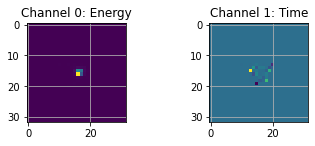

In [24]:
plt.figure(1)

plt.subplot(221)
plt.imshow(X_train[1,:,:,0])
plt.title("Channel 0: Energy")  # Energy
plt.grid(True)

plt.subplot(222)
plt.imshow(X_train[1,:,:,1])
plt.title("Channel 1: Time")  # Time
plt.grid(True)


plt.show()

# Define CNN Model
This is a sample model. You can experiment with the model and try various architectures and other models to achieve the highest possible performance.  

In [25]:
### Define Convolutional Neural Network (CNN) Model ###

model = Sequential()
model.add(Conv2D(16, activation='relu', kernel_size=3, padding='same', kernel_initializer='TruncatedNormal', input_shape=(img_rows, img_cols, nb_channels)))
model.add(Conv2D(16, activation='relu', kernel_size=3, padding='same', kernel_initializer='TruncatedNormal'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, activation='relu', kernel_size=3, padding='same', kernel_initializer='TruncatedNormal'))
model.add(Conv2D(32, activation='relu', kernel_size=3, padding='same', kernel_initializer='TruncatedNormal'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer='TruncatedNormal'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu', kernel_initializer='TruncatedNormal'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid', kernel_initializer='TruncatedNormal'))
model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 16)        304       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 16)        2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)             

## Train the Model
You may further optimize the model, tune hyper-parameters, etc. accordingly to achieve the best performance possible.

In [26]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1.e-6)
history=model.fit(X_train, y_train,\
        batch_size=batch_size,\
        epochs=epochs,\
        validation_data=(X_valid, y_valid),\
        callbacks=[reduce_lr],\
        verbose=1, shuffle=True)

Epoch 1/20
128/128 [==============================] - 38s 298ms/step - loss: 0.6909 - accuracy: 0.5251 - val_loss: 0.6880 - val_accuracy: 0.5752
Epoch 2/20
128/128 [==============================] - 31s 244ms/step - loss: 0.6696 - accuracy: 0.5890 - val_loss: 0.6628 - val_accuracy: 0.5996
Epoch 3/20
128/128 [==============================] - 30s 233ms/step - loss: 0.6588 - accuracy: 0.6057 - val_loss: 0.6588 - val_accuracy: 0.6079
Epoch 4/20
128/128 [==============================] - 37s 292ms/step - loss: 0.6522 - accuracy: 0.6187 - val_loss: 0.6660 - val_accuracy: 0.6055
Epoch 5/20
128/128 [==============================] - 43s 335ms/step - loss: 0.6492 - accuracy: 0.6235 - val_loss: 0.6670 - val_accuracy: 0.6035
Epoch 6/20
128/128 [==============================] - 37s 291ms/step - loss: 0.6383 - accuracy: 0.6350 - val_loss: 0.6562 - val_accuracy: 0.6089
Epoch 7/20
128/128 [==============================] - 40s 313ms/step - loss: 0.6360 - accuracy: 0.6415 - val_loss: 0.6564 - val_ac

## Evaluate the Model  
Along with the model accuracy, the prefered metric for evaluation is ROC (Receiver Operating Characteristic) curve and the AUC score (Area under the ROC Curve).

In [19]:
# Evaluate on validation set
score = model.evaluate(X_valid, y_valid, verbose=1)
print('\nValidation loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = model.predict(X_valid)
fpr, tpr, _ = roc_curve(y_valid, y_pred)
roc_auc = auc(fpr, tpr)
print('Validation ROC AUC:', roc_auc)

# Evaluate on test set
score = model.evaluate(X_test, y_test, verbose=1)
print('\nTest loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('Test ROC AUC:', roc_auc)

64/64 [==============================] - 3s 47ms/step - loss: 0.6829 - accuracy: 0.5718

Validation loss / accuracy: 0.6829 / 0.5718
Validation ROC AUC: 0.6062235832214355
64/64 [==============================] - 3s 45ms/step - loss: 0.6804 - accuracy: 0.5752

Test loss / accuracy: 0.6804 / 0.5752
Test ROC AUC: 0.6135940551757812


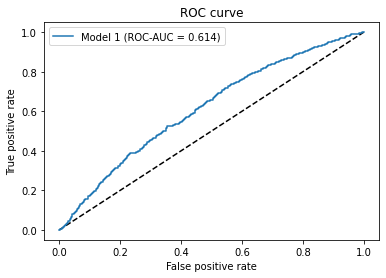

In [20]:
plt.plot([0, 1], [0, 1], 'k--')
#plt.legend(loc=2, prop={'size': 15})
plt.plot(fpr, tpr, label='Model 1 (ROC-AUC = {:.3f})'.format(roc_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# Submission format: 
Submit the Google Colab Jupyter Notebook demonstrating your solution in the similar format as illustrated in this notebook. It should contain:
*   The final model architecture, parameters and hyper-parameters yielding the best possible performance,
*   Its Training and Validation accuracy, 
*   ROC curve and the AUC score as shown above.
*   Also, please submit the final trained model containing the model architecture and its trained weights along with this notebook (For example: HDF5 file, .pb file, .pt file, etc.). Either in this notebook or in a separate notebook show how to load and use your model.